In [1]:
import numpy as np
import pandas as pd
import glob

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

# Define the data path (update the path accordingly)
path = '/kaggle/input/march-machine-learning-mania-2025/**'

# Load all CSV files from the dataset directory into a dictionary
# The key is the filename (without extension), and the value is the corresponding DataFrame
data = {p.split('/')[-1].split('.')[0]: pd.read_csv(p, encoding='latin-1') for p in glob.glob(path)}

# Add Gender marker before concatenating teams (M for Men's, W for Women's)
data['MTeams']['Gender'] = '1'
data['WTeams']['Gender'] = '0'

# Merge men's and women's team data into a single DataFrame
teams = pd.concat([data['MTeams'], data['WTeams']])

# Merge team spellings and count variations for each TeamID
teams_spelling = pd.concat([data['MTeamSpellings'], data['WTeamSpellings']])
teams_spelling = teams_spelling.groupby('TeamID', as_index=False).size()
teams_spelling.columns = ['TeamID', 'TeamNameCount']

# Merge spelling variations count with the teams DataFrame
teams = teams.merge(teams_spelling, how='left', on='TeamID')

del teams_spelling  # Clean up memory

# Merge season results (compact and detailed) for men's and women's data
season_cresults = pd.concat([data['MRegularSeasonCompactResults'], data['WRegularSeasonCompactResults']])
season_dresults = pd.concat([data['MRegularSeasonDetailedResults'], data['WRegularSeasonDetailedResults']])
tourney_cresults = pd.concat([data['MNCAATourneyCompactResults'], data['WNCAATourneyCompactResults']])
tourney_dresults = pd.concat([data['MNCAATourneyDetailedResults'], data['WNCAATourneyDetailedResults']])
slots = pd.concat([data['MNCAATourneySlots'], data['WNCAATourneySlots']])
seeds = pd.concat([data['MNCAATourneySeeds'], data['WNCAATourneySeeds']])
gcities = pd.concat([data['MGameCities'], data['WGameCities']])
seasons = pd.concat([data['MSeasons'], data['WSeasons']])

# Convert seeds into a dictionary where keys are "Season_TeamID" and values are numeric seed values
seeds = {'_'.join(map(str, [int(k1), k2])): int(v[1:3]) for k1, v, k2 in seeds[['Season', 'Seed', 'TeamID']].values}

# Load other relevant data
cities = data['Cities']
sub = data['SampleSubmissionStage2']
del data  # Clean up memory

# Add season type labels to the game results datasets
season_cresults['ST'] = 'S'
season_dresults['ST'] = 'S'
tourney_cresults['ST'] = 'T'
tourney_dresults['ST'] = 'T'

# Combine detailed season and tournament results
# Only detailed results are used since they contain richer statistics
games = pd.concat([season_dresults, tourney_dresults], axis=0, ignore_index=True)
games.reset_index(drop=True, inplace=True)

# Map win location to numerical values
games['WLoc'] = games['WLoc'].map({'A': 1, 'H': 2, 'N': 3})

# Generate unique game identifiers and related team IDs
games['ID'] = games.apply(lambda r: '_'.join(map(str, [r['Season']] + sorted([r['WTeamID'], r['LTeamID']]))), axis=1)
games['IDTeams'] = games.apply(lambda r: '_'.join(map(str, sorted([r['WTeamID'], r['LTeamID']]))), axis=1)
games['Team1'], games['Team2'] = zip(*games[['WTeamID', 'LTeamID']].apply(lambda x: sorted(x), axis=1))
games['IDTeam1'] = games.apply(lambda r: f"{r['Season']}_{r['Team1']}", axis=1)
games['IDTeam2'] = games.apply(lambda r: f"{r['Season']}_{r['Team2']}", axis=1)

# Map team seeds to the games dataset
games['Team1Seed'] = games['IDTeam1'].map(seeds).fillna(0)
games['Team2Seed'] = games['IDTeam2'].map(seeds).fillna(0)

games['ScoreDiff'] = games['WScore'] - games['LScore']

# Label the winning team as Team1 for predictions
games['Pred'] = (games['WTeamID'] == games['Team1']).astype(float)

games['ScoreDiffNorm'] = games['ScoreDiff'] * (-1 + 2 * games['Pred'])
games['SeedDiff'] = games['Team1Seed'] - games['Team2Seed']

games.fillna(-1, inplace=True)  # Fill missing values with -1

# Select statistics columns for aggregation
c_score_col = ['NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl',
 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl',
 'LBlk', 'LPF']

c_score_agg = ['sum', 'mean', 'median', 'max', 'min', 'std', 'skew', 'nunique']

# Aggregate statistics for each game pair
gb = games.groupby('IDTeams').agg({k: c_score_agg for k in c_score_col}).reset_index()

# Rename columns for clarity
gb.columns = [''.join(c) + '_c_score' for c in gb.columns]

games = games[games['ST'] == 'T']  # Keep only tournament games

# Prepare submission dataset
sub['WLoc'] = 3
sub[['Season', 'Team1', 'Team2']] = sub['ID'].str.split('_', expand=True).astype(int)
sub['IDTeams'] = sub.apply(lambda r: f"{r['Team1']}_{r['Team2']}", axis=1)
sub['IDTeam1'] = sub.apply(lambda r: f"{r['Season']}_{r['Team1']}", axis=1)
sub['IDTeam2'] = sub.apply(lambda r: f"{r['Season']}_{r['Team2']}", axis=1)
sub['Team1Seed'] = sub['IDTeam1'].map(seeds).fillna(0)
sub['Team2Seed'] = sub['IDTeam2'].map(seeds).fillna(0)
sub['SeedDiff'] = sub['Team1Seed'] - sub['Team2Seed']
sub.fillna(-1, inplace=True)

# Merge aggregated game stats with the tournament dataset
games = games.merge(gb, how='left', left_on='IDTeams', right_on='IDTeams_c_score')
sub = sub.merge(gb, how='left', left_on='IDTeams', right_on='IDTeams_c_score')

sub = sub.merge(teams[['TeamID', 'Gender']], how='left', left_on='Team1', right_on='TeamID', suffixes=('', '_Gender'))
games = games.merge(teams[['TeamID', 'Gender']], how='left', left_on='Team1', right_on='TeamID', suffixes=('', '_Gender'))

# Exclude columns not needed for model training
col = [c for c in games.columns if c not in ['ID', 'DayNum', 'ST', 'Team1', 'Team2', 'IDTeams', 'IDTeam1', 'IDTeam2', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'NumOT', 'Pred', 'ScoreDiff', 'ScoreDiffNorm', 'WLoc'] + c_score_col]

In [2]:
# Check for columns with NaN values
nan_columns = games.isna().sum()

# Print the number of columns with NaN values
nan_columns_with_values = nan_columns[nan_columns > 0]

# Print statistics about columns with NaN values
print(f"Total columns with NaN values: {len(nan_columns_with_values)}")
print(f"Columns with NaN values: \n{nan_columns_with_values}")

Total columns with NaN values: 54
Columns with NaN values: 
NumOTstd_c_score      944
NumOTskew_c_score    1476
WFGMstd_c_score       944
WFGMskew_c_score     1476
WFGAstd_c_score       944
WFGAskew_c_score     1476
WFGM3std_c_score      944
WFGM3skew_c_score    1476
WFGA3std_c_score      944
WFGA3skew_c_score    1476
WFTMstd_c_score       944
WFTMskew_c_score     1476
WFTAstd_c_score       944
WFTAskew_c_score     1476
WORstd_c_score        944
WORskew_c_score      1476
WDRstd_c_score        944
WDRskew_c_score      1476
WAststd_c_score       944
WAstskew_c_score     1476
WTOstd_c_score        944
WTOskew_c_score      1476
WStlstd_c_score       944
WStlskew_c_score     1476
WBlkstd_c_score       944
WBlkskew_c_score     1476
WPFstd_c_score        944
WPFskew_c_score      1476
LFGMstd_c_score       944
LFGMskew_c_score     1476
LFGAstd_c_score       944
LFGAskew_c_score     1476
LFGM3std_c_score      944
LFGM3skew_c_score    1476
LFGA3std_c_score      944
LFGA3skew_c_score    1476
LFTM

In [3]:
from catboost import CatBoostClassifier
import pandas as pd
import optuna

cat_features = [col for col in games[col].select_dtypes(include=['object', 'category']).columns]

X = games[col].fillna(-1)
y = games['Pred']

# Define objective function for Optuna
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 500, 2000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "loss_function": "Logloss",
        "random_seed": 42,
        "verbose": 1000  
    }
    
    # Train model
    model = CatBoostClassifier(**params)
    model.fit(X, y, cat_features=cat_features, eval_set=(X, y), early_stopping_rounds=100, verbose=0)
    
    # Evaluate model using best iteration
    best_score = model.best_score_['validation']['Logloss']
    
    return best_score

# Optimize with Optuna
#study = optuna.create_study(direction="minimize")  # We minimize Logloss
#study.optimize(objective, n_trials=50)  # Run 50 trials

# Get best parameters
#best_params = study.best_params
#print("Best Parameters:", best_params)


best_params = {
    'iterations': 1551,
    'depth': 9,
    'learning_rate': 0.10698960369265217,
    'l2_leaf_reg': 0.0010976350999793716,
    'border_count': 84,
    'loss_function': 'Logloss',
    'random_seed': 42,
    'verbose': 100  # Show training progress every 100 iterations
}

# Initialize CatBoostClassifier with best parameters
model = CatBoostClassifier(**best_params)

# Train final model with best parameters
model.fit(X, y, cat_features=cat_features, verbose=100)

0:	learn: 0.6438135	total: 122ms	remaining: 3m 8s
100:	learn: 0.0211692	total: 5.22s	remaining: 1m 15s
200:	learn: 0.0009519	total: 10.3s	remaining: 1m 9s
300:	learn: 0.0003862	total: 15.2s	remaining: 1m 3s
400:	learn: 0.0003476	total: 20.6s	remaining: 59.1s
500:	learn: 0.0003392	total: 25.3s	remaining: 53.1s
600:	learn: 0.0003219	total: 29.6s	remaining: 46.8s
700:	learn: 0.0002937	total: 34.3s	remaining: 41.6s
800:	learn: 0.0002936	total: 39.1s	remaining: 36.6s
900:	learn: 0.0002935	total: 43.9s	remaining: 31.7s
1000:	learn: 0.0002934	total: 48.4s	remaining: 26.6s
1100:	learn: 0.0002933	total: 53.5s	remaining: 21.9s
1200:	learn: 0.0002849	total: 58.2s	remaining: 17s
1300:	learn: 0.0002848	total: 1m 2s	remaining: 12.1s
1400:	learn: 0.0002758	total: 1m 7s	remaining: 7.22s
1500:	learn: 0.0002757	total: 1m 12s	remaining: 2.4s
1550:	learn: 0.0002756	total: 1m 14s	remaining: 0us


Pred
1.0    1141
0.0    1135
Name: count, dtype: int64


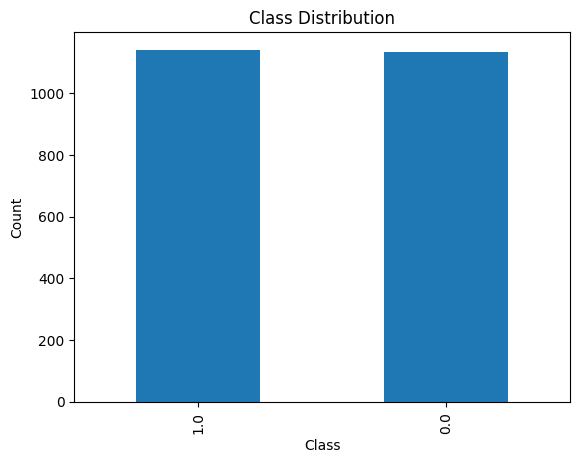

,Season,Team1Seed,Team2Seed,SeedDiff,IDTeams_c_score,NumOTsum_c_score,NumOTmean_c_score,NumOTmedian_c_score,NumOTmax_c_score,NumOTmin_c_score,...,LPFsum_c_score,LPFmean_c_score,LPFmedian_c_score,LPFmax_c_score,LPFmin_c_score,LPFstd_c_score,LPFskew_c_score,LPFnunique_c_score,TeamID,Gender
0,2003,16.0,16.0,0.0,1411_1421,1,1.00,1.0,1,1,...,22,22.000000,22.0,22,22,-1.000000,-1.000000,1,1411,1
1,2003,1.0,16.0,-15.0,1112_1436,0,0.00,0.0,0,0,...,15,15.000000,15.0,15,15,-1.000000,-1.000000,1,1112,1
2,2003,10.0,7.0,3.0,1113_1272,0,0.00,0.0,0,0,...,18,18.000000,18.0,18,18,-1.000000,-1.000000,1,1113,1
3,2003,11.0,6.0,5.0,1141_1166,0,0.00,0.0,0,0,...,35,17.500000,17.5,21,14,4.949747,-1.000000,2,1141,1
4,2003,8.0,9.0,-1.0,1143_1301,1,0.25,0.0,1,0,...,66,16.500000,17.0,19,13,2.645751,-0.863919,4,1143,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2271,2024,3.0,1.0,2.0,3163_3425,0,0.00,0.0,0,0,...,32,16.000000,16.0,20,12,5.656854,-1.000000,2,3163,0
2272,2024,1.0,3.0,-2.0,3234_3261,0,0.00,0.0,0,0,...,40,20.000000,20.0,21,19,1.414214,-1.000000,2,3234,0
2273,2024,3.0,1.0,2.0,3163_3234,0,0.00,0.0,0,0,...,35,11.666667,10.0,18,7,5.686241,1.205659,3,3163,0
2274,2024,3.0,1.0,2.0,3301_3376,0,0.00,0.0,0,0,...,104,14.857143,15.0,22,8,5.014265,-0.159771,6,3301,0


In [4]:
# Check the distribution of the target variable 'Result'
class_distribution = y.value_counts()

# Print the distribution of the target variable
print(class_distribution)

# Optionally, you can also visualize it using a bar plot
import matplotlib.pyplot as plt

class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

X

In [5]:
# Set pandas display option to avoid scientific notation
pd.options.display.float_format = '{:.2f}'.format

# Get feature importance
feature_importances = model.get_feature_importance()

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

#pd.set_option("display.max_rows", None)

# Print feature importance
feature_importance_df

,Feature,Importance
3,SeedDiff,6.56
1,Team1Seed,5.48
2,Team2Seed,4.27
0,Season,2.82
4,IDTeams_c_score,2.23
...,...,...
20,WFGMnunique_c_score,0.00
5,NumOTsum_c_score,0.00
52,WFTMnunique_c_score,0.00
12,NumOTnunique_c_score,0.00


In [6]:
import pandas as pd

sub_X = sub[col].fillna(-1)

# Generate predictions using the trained model and clip values between 0.001 and 0.999
sub['Pred'] = model.predict(sub_X).clip(0.001, 0.999)

# Fill NaNs in the predictions (you can use 0, mean, or another strategy)
sub['Pred'] = sub['Pred'].fillna(-1)  # Replace -1 with an appropriate strategy if needed

# Save final predictions to a CSV file for submission
sub[['ID', 'Pred']].to_csv('submission.csv', index=False)

pd.set_option('display.max_columns', None)

# First merge for Team1
sub = sub.merge(teams[['TeamID', 'TeamName']], how='left', left_on='Team1', right_on='TeamID', suffixes=('_1', ''))

# Rename columns to avoid duplicate column names
sub = sub.rename(columns={'TeamName': 'TeamName_1', 'TeamID': 'TeamID_1'})

# Second merge for Team2
sub = sub.merge(teams[['TeamID', 'TeamName']], how='left', left_on='Team2', right_on='TeamID', suffixes=('', '_2'))

# Rename columns after the second merge
sub = sub.rename(columns={'TeamName': 'TeamName_2', 'TeamID': 'TeamID_2'})

# Now you can select the columns you want
sub[['ID', 'Pred', 'Team1', 'Team2', 'TeamName_1', 'TeamName_2', 'Gender']]

,ID,Pred,Team1,Team2,TeamName_1,TeamName_2,Gender
0,2025_1101_1102,0.00,1101,1102,Abilene Chr,Air Force,1
1,2025_1101_1103,1.00,1101,1103,Abilene Chr,Akron,1
2,2025_1101_1104,1.00,1101,1104,Abilene Chr,Alabama,1
3,2025_1101_1105,1.00,1101,1105,Abilene Chr,Alabama A&M,1
4,2025_1101_1106,1.00,1101,1106,Abilene Chr,Alabama St,1
...,...,...,...,...,...,...,...
131402,2025_3477_3479,0.00,3477,3479,East Texas A&M,Mercyhurst,0
131403,2025_3477_3480,0.00,3477,3480,East Texas A&M,West Georgia,0
131404,2025_3478_3479,0.00,3478,3479,Le Moyne,Mercyhurst,0
131405,2025_3478_3480,0.00,3478,3480,Le Moyne,West Georgia,0
